In [1]:
import yaml
import os
from pathlib import Path
import pandas as pd
import struct
import random
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import sys
import math
import re

# also: cd hammer && pip install -e . 

# Setup

In [2]:
# experiment setup
PDK = 'sky130'
CLOCK_PERIOD = 10 if PDK == 'sky130' else 2 # ns

# generate custom make str for each test
make_extra = f"pdk={PDK}"
if PDK == 'intech22': make_extra += f" PDK_CONF=experiments/intech22.yml"

# useful paths
energy_char_dpath = Path(os.getcwd()).parent
tests_dpath = energy_char_dpath/f'experiments/tests-{PDK}'
tests_dpath

PosixPath('/bwrcq/scratch/nayiri/hammer-sep24/e2e/hammer-energy-char/experiments/tests-sky130')

# Generate experiment files

In [3]:
# get pdk clock periods, paths
PDKs = ["sky130"]
test_paths = {}
for pdk in PDKs:
    test_paths[pdk] = energy_char_dpath/f'experiments/tests-{pdk}'

operations = ['add', 'mul']
op_to_inst = {'add':'adder0', 'mul':'multiplier0'}
num_inputs = 50
widths = [4, 8, 16, 32, 64]
activity_factors = [0.1, 0.5, 0.9, 1.0] # eventually include: 0.3,0.7
clock_periods = [CLOCK_PERIOD] # ns, clock periods to apply to all designs; eventually try sweeping this

width_to_max = {}
for i in widths:
    width_to_max[i] = (1 << i) - 1

design_minclock_dict = {}
# optional:
# design_minclock_dict={'add4': 4, 'add8': 4, 'add16': 4, 'add32': 4, 'add64': 4, 'mul4': 5, 'mul8': 5, 'mul16': 6, 'mul32': 6, 'mul64': 5}

'''
tests dict
  name format: <design>-<test_name>
      inputs: list, where each item is a tuple of items per line in input.txt
      defines: for verilog
'''

'\ntests dict\n  name format: <design>-<test_name>\n      inputs: list, where each item is a tuple of items per line in input.txt\n      defines: for verilog\n'

In [4]:
# # smoke test:
# operations = ['add']
# widths = [4]
# activity_factors = [0]

## Activity Factor Based Input Generation

In [5]:
## get binary string
def getBinary(num, width):
	binary_str = ""
	for i in range(width):
		if (num & (1 << i)):
			binary_str += '1'
		else:
			binary_str += '0'
	return binary_str[::-1]

## find (a, b) s.t. a + b = num
def findNums(num, operation, tryall):
	a, b = 0, 0
	if (operation == 'add'):
		a = random.randint(0, num)
		b = num - a
	elif (operation == 'mul'):
		a, b = 1, num
		if (tryall): ## get all factors of num and choose a pair at random
			allpairs = []
			for i in range(1, int(num ** 0.5) + 1):
				if (num % i == 0):
					allpairs.append((i, num // i))
			a, b = allpairs[random.randint(0, len(allpairs) - 1)]
	return (a, b)


## flip the output (cur_num) given the width and activity factor (prob)
def flip(cur_num, width, prob):
	ret = 0
	for i in range(width):
		on = ((cur_num & (1 << i)) > 0)
		rand_num = random.random()
		## flip bit
		if (rand_num <= prob):
			ret += ((not on) * (1 << i))
		else:
			ret += (on * (1 << i))
	return ret

## verify that the integer pairs (nums) generated from a specified width and activity factor are sensible
def output(width, factor, nums):
	print(f'Width: {width}, Activity Factor: {factor}')
	prev = ""
	for (a, b) in nums:
		print((a, b))
		binary_str = getBinary(a + b, width)
		print(f'New Binary String: {binary_str}')
		if (prev):
			pc = sum([0 if binary_str[i] == prev[i] else 1 for i in range(width)]) / width
			print(f'Percent change: {pc}')
		prev = binary_str


def getInputs(width, activity_factor, num_iter, operation, tryall):
	nums = [(0, 0)]
	for i in range(num_iter - 1):
		new_num = flip(sum(nums[-1]), width, activity_factor)
		nums.append(findNums(new_num, operation, tryall))
	#output(width, activity_factor, nums) #<-- USE THIS TO VERIFY THAT INPUT PAIRS ARE LOGICAL
	return nums

In [6]:
def getMaxInputSwitching(num, operation):
    return (num, num)

def getMaxOutputSwitching(num, operation):
    if (operation == 'add'):
        a = int(num/2)
        b = num - a
        return (a, b)
    elif (operation == 'mul'):
        return (1, num)


## Generate All Testbenchs

In [7]:
def writeYaml(td):
    defines_str = '\n'.join( [ f"  - {key}={val}" for key,val in td['defines'].items() ] )
    clock_period = td["clock_period"]
    delays = [f"""{{name: {i}, clock: {td['clock']}, delay: "1", direction: input}}""" for i in td['input_ports']]
    delays += [f"""{{name: {i}, clock: {td['clock']}, delay: "1", direction: output}}""" for i in td['output_ports']]
    delays = ',\n  '.join(delays)
    cfg = f"""\
vlsi.core.build_system: make
vlsi.inputs.power_spec_type: cpf
vlsi.inputs.power_spec_mode: auto

design.defines: &DEFINES
  - CLOCK_PERIOD={clock_period}
{defines_str}

vlsi.inputs.clocks: [{{name: "clock", period: "{clock_period}ns", uncertainty: "100ps"}}]

vlsi.inputs.delays: [
  {delays}
]

synthesis.inputs:
  top_module: {td['top_module']}
  input_files: {td['vsrcs']}
  defines: *DEFINES

sim.inputs:
  top_module: {td['top_module']}
  tb_name: {td['tb_name']}
  tb_dut: {td['tb_dut']}
  options: ["-timescale=1ns/10ps", "-sverilog"]
  options_meta: append
  defines: *DEFINES
  defines_meta: append
  level: rtl
  input_files: {td['vsrcs'] + td['vsrcs_tb']}

vlsi.core.power_tool: hammer.power.joules
power.inputs:
  level: rtl
  top_module: {td['top_module']}
  tb_name: {td['tb_name']}
  tb_dut: {td['tb_dut']}
  defines: *DEFINES
  input_files: {td['vsrcs']}
  report_configs:
    - waveform_path: {td['root']}/output.fsdb
      report_stem: {td['root']}/power
      toggle_signal: {td['clock']}
      num_toggles: 1
      levels: all
      output_formats:
      - report
      - plot_profile
      - ppa
"""
    with (td['root']/'config.yml').open('w') as f:
        f.write(cfg)

In [8]:
def decimalFormat(factor):
    sf = str(factor).replace('.','p')
    sf = sf.replace('p0','') # 1p0 --> 1
    return sf

def createTest(operation, width, factor, clock_period):
    design = f"{operation}{width}-{clock_period}ns"
    #print(decimalFormat(factor))
    test_name = f'{design}-{decimalFormat(factor)}'

    ## set inputs
    new_test = {'inputs': getInputs(width, factor, num_inputs, operation, 0), 'defines': dict(WIDTH=width)}
    if (factor > 1):
        new_test['inputs'] = [(0, width_to_max[width]) if i % 2 == 0 else (width_to_max[width], 1) for i in range(num_inputs)]
    

    new_test['operation'] = operation
    new_test['width'] = width
    new_test['output_af'] = factor

    ## verilog info
    new_test['design'] = design
    new_test['inst'] = f'/{operation}/{op_to_inst[operation]}'
    new_test['clock'] = 'clock'
    new_test['vsrcs'] = [f'src/{operation}.v']
    new_test['vsrcs_tb'] = [f'src/{operation}_tb.v']
    new_test['top_module'] = f'{operation}'
    new_test['tb_name'] = f'{operation}_tb'
    new_test['tb_dut'] = f'{operation}_dut'
    new_test['input_ports'] = ['in0','in1']
    new_test['output_ports'] = ['out']
    new_test['clock_period'] = clock_period

    ## root dir
    root = tests_dpath/test_name
    root.mkdir(exist_ok=True,parents=True)
    new_test['defines']['TESTROOT'] = root
    new_test['root'] = root

    ## design dir
    new_test['obj_dpath'] = energy_char_dpath/f"build-{PDK}-cm/{design}"

    cfg = str(new_test['root']/'config.yml')
    new_test['make'] = f"design={new_test['design']} {make_extra} DESIGN_CONF={cfg}"

    return test_name, new_test

# convert data operands to binary format to dump to input.txt (gets more complicated for floats)
def val2binary(val,input_format='') -> str:
    if type(val) == str: return val
    elif type(val) == int: return '{0:b}'.format(val)
    elif type(val) == float:
        pack_format = '!e'
        if input_format == 'float32':       pack_format = '!f'
        elif input_format == 'float64':     pack_format = '!d'
        return ''.join('{:0>8b}'.format(c) for c in struct.pack(pack_format, val))
    else: assert(False), f"Invalid dtype, {type(val)}"

def writeInput(test_info):
    input_format = test_info['input_format'] if 'input_format' in test_info else ''
    with (test_info['root']/'input.txt').open('w') as f:
        for operands in test_info['inputs']:
            f.write(" ".join([val2binary(operand,input_format) for operand in operands]) + '\n')



tests_dict = {}
for operation in operations:
    for width in widths:
        design = operation+str(width)
        design_clock_periods = clock_periods.copy()
        if design in design_minclock_dict:
            design_clock_periods.append(design_minclock_dict[design])
        for clock_period in design_clock_periods:
            for factor in activity_factors:
                test_name, test_info = createTest(operation, width, factor, clock_period)
                writeInput(test_info)
                writeYaml(test_info)
                tests_dict[test_name] = test_info


## Run experiments

In [9]:
# Setup
def runMakeCmd(make_target,td,fp,overwrite=False,verbose=False):
    if overwrite or not fp.exists():
        cmd = f"make {make_target} {td['make']}"
        print(f'Executing commmand: {cmd}')
        subprocess.run(cmd, cwd=energy_char_dpath,
                        shell=True, check=True, capture_output=(not verbose))

# subprocess.run starts in an empty environment, need to ensure it can find hammer-vlsi
python_exec_fpath = Path(sys.executable)
env_dpath = str(python_exec_fpath.parent)
if not os.environ['PATH'].startswith(env_dpath): os.environ['PATH'] = env_dpath + ':' + os.environ['PATH']

def runBuild(td,overwrite=False,verbose=False):
    runMakeCmd("build -B",td,
                td['obj_dpath'],
                overwrite,verbose)

def runSim(td,overwrite=False,verbose=False):
    runMakeCmd("redo-sim-rtl",td,
                td['root']/'output.fsdb',
                overwrite,verbose)

def runPowerSyn(td,overwrite=False,verbose=False):
    runMakeCmd("power-rtl",td,
                td['obj_dpath']/'power-rtl-rundir/pre_report_power',
                overwrite,verbose)

def runPowerReport(td,overwrite=False,verbose=False):
    runMakeCmd("redo-power-rtl args='--only_step report_power'",td,
                td['root']/'power.power.rpt',
                overwrite,verbose)


In [10]:
# build
overwrite = False
build_dpaths = {td['obj_dpath']: t for t,td in tests_dict.items()} # run build once per build dir (not once per test)
for bd,t in build_dpaths.items():
    runBuild(tests_dict[t],overwrite)

In [11]:
# power-rtl: synthesize design in power tool + save checkpoint
overwrite = False
for bd,t in build_dpaths.items():
    runSim(tests_dict[t],overwrite)
    runPowerSyn(tests_dict[t],overwrite)
    runPowerReport(tests_dict[t],overwrite)

In [12]:
# TODO: check ppa.rpt & adjust clock period, print updated values
#       in a dict that user copies to the top? it's a bit messy but we prolly don't want to auto-loop

def parseSlack(fname):
    slacks = []
    with open(fname, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.split()
            if (line[0] == 'register'):
                slacks.append(float(line[6]))
    return min(slacks)

overwrite = False
new_clocks = {}
for bd,t in build_dpaths.items():
    cur_test = tests_dict[t]
    clock_period = cur_test['clock_period']
    slack = parseSlack(cur_test['root']/'power.ppa.rpt')
    if 0 <= slack and slack < 500: slack = 0 # don't change clock period
    new_clock_period = math.floor((clock_period * 1000 - slack) / 1000)
    new_clocks[t.split('-')[0]] = new_clock_period

print(f"design_minclock_dict={new_clocks}")
# copy output to top if desired

design_minclock_dict={'add4': 4, 'add8': 4, 'add16': 4, 'add32': 4, 'add64': 4, 'mul4': 5, 'mul8': 5, 'mul16': 6, 'mul32': 6, 'mul64': 5}


In [13]:
# sim-rtl
for t,td in tests_dict.items():
    runSim(td, overwrite=False, verbose=False)
    runPowerReport(td, overwrite=False, verbose=False)

## Parse results

In [14]:
def parse_hier_power_rpt(td) -> list:
    fpath = td['root']/'power.hier.power.rpt'
    with fpath.open('r') as f: lines = f.readlines()
    for l in lines:
        words = l.split()
        if l.startswith('Power Unit'):
            assert(words[-1] == 'mW'), f"Wrong power unit in report, {l}"
        if td['inst'] == words[-1]:
            return [float(p) for p in words[2:6]]
    return []

def parse_power_profile(td) -> float:
    fpath = td['root']/'power.profile.png.data'
    with fpath.open('r') as f: lines = f.readlines()
    header = lines[0]
    assert(f"-ykeylabel {td['inst']}:total:total" in header) # make sure we got the correct power trace
    match = re.search(r'simulation time \((\w+)\)', header)
    unit = match.group(1) if match else None
    if unit == 'ns': scaling = 1
    elif unit == 'ps': scaling = 1e-3
    elif unit == 'fs': scaling = 1e-6
    else: raise ValueError(f"Unit {unit} not supported in file {fpath}")
    time_power = [l.split() for l in lines]
    time_power = [tp for tp in time_power if len(tp) == 2]
    times = [float(t)*scaling for t,p in time_power]
    powers = [float(p) for t,p in time_power][1:-1] # skip first/last values bc they're misleading
    avgpow = sum(powers)/len(powers)
    return times[-1]-times[0], avgpow # end-start


power = []

for t,td in tests_dict.items():
    power.append(parse_hier_power_rpt(td))

power = pd.DataFrame(power,   #  mW
                     columns=['Leakage','Internal','Switching','Total'],
                     index=tests_dict.keys()) # type: ignore


time_ns = [parse_power_profile(td)[0] for td in tests_dict.values()]
energy = power.mul(time_ns,axis=0) / num_inputs # mW * ns = pJ
energy.columns = [c+' Energy (pJ)' for c in energy.columns]
database = pd.concat([energy,power],axis=1)

database.insert(0,'output_af',[td['output_af'] for td in tests_dict.values()])
database.insert(0,'time_ns',time_ns)
database.insert(0,'test',[i.split('-')[1] for i in database.index])
database.insert(0,'design',[i.split('-')[0] for i in database.index])

#print(results_for_plots)
database.to_hdf(PDK+'.h5',key='df',mode='w')
database


,design,test,time_ns,output_af,Leakage Energy (pJ),Internal Energy (pJ),Switching Energy (pJ),Total Energy (pJ),Leakage,Internal,Switching,Total
add4-10ns-0p1,add4,10ns,505.0,0.1,7.151709e-07,0.063601,0.568659,0.632261,7.080900e-08,0.006297,0.056303,0.062600
add4-10ns-0p5,add4,10ns,505.0,0.5,7.240690e-07,0.165920,3.452624,3.618547,7.169000e-08,0.016428,0.341844,0.358272
add4-10ns-0p9,add4,10ns,505.0,0.9,7.183524e-07,0.235843,5.612984,5.848819,7.112400e-08,0.023351,0.555741,0.579091
add4-10ns-1,add4,10ns,505.0,1.0,7.135448e-07,0.259311,6.384028,6.643346,7.064800e-08,0.025674,0.632082,0.657757
add8-10ns-0p1,add8,10ns,505.0,0.1,1.512273e-06,0.217663,1.326867,1.544532,1.497300e-07,0.021551,0.131373,0.152924
add8-10ns-0p5,add8,10ns,505.0,0.5,1.510415e-06,0.351528,6.100602,6.452133,1.495460e-07,0.034805,0.604020,0.638825
add8-10ns-0p9,add8,10ns,505.0,0.9,1.505385e-06,0.541397,11.606213,12.147573,1.490480e-07,0.053604,1.149130,1.202730
add8-10ns-1,add8,10ns,505.0,1.0,1.502920e-06,0.548918,12.771854,13.320789,1.488040e-07,0.054348,1.264540,1.318890
add16-10ns-0p1,add16,10ns,505.0,0.1,3.260724e-06,0.384659,2.313173,2.697831,3.228440e-07,0.038085,0.229027,0.267112
add16-10ns-0p5,add16,10ns,505.0,0.5,3.264734e-06,0.807421,13.153634,13.961028,3.232410e-07,0.079943,1.302340,1.382280


## Generate Plot

''

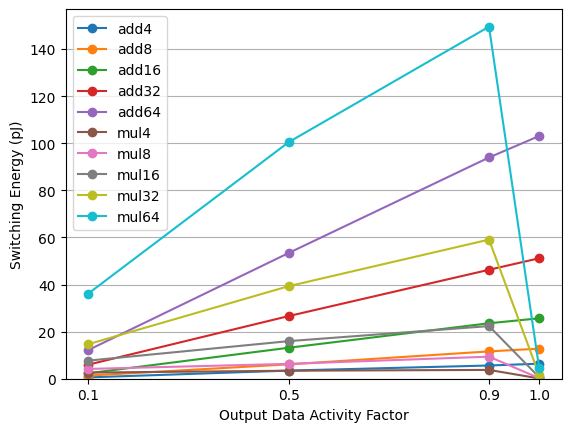

In [15]:
ykey = 'Switching Energy (pJ)'
# ykey = 'Internal (pJ)'

designs =  list(dict.fromkeys(database['design']).keys())
for design in designs:
    df = database[~database['output_af'].isna() & (database['design'] == design)].sort_values('output_af')
    hd = df['output_af']
    e = df[ykey]
    plt.plot(hd,e,'o-',label=design)
    plt.xticks(hd)


plt.legend()
plt.xlabel('Output Data Activity Factor')
plt.ylabel(ykey)
plt.grid(axis='y')
plt.ylim(bottom=0)
;

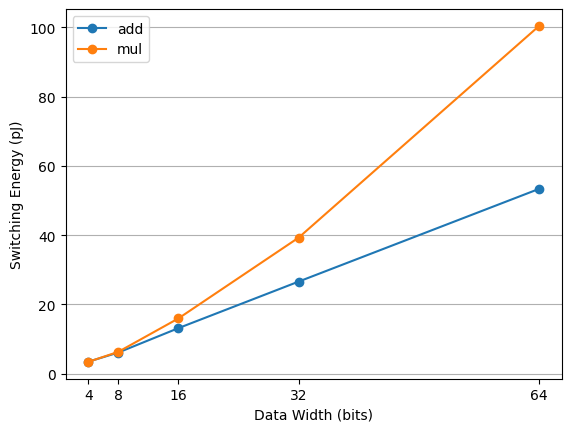

In [16]:
ykey = "Switching Energy (pJ)"

data = database[database['output_af'] == 0.5]
for operation in operations:
    widths, skip = [], []
    ind = 0
    for val in data['design']:
        if operation in val:
            widths.append(int(val.replace(operation,'')))
        else:
            skip.append(ind)
        ind += 1
    energies = data[ykey].values
    valid_energies = []
    for i in range(len(energies)):
        if i not in skip:
            valid_energies.append(energies[i])
    # print(widths, valid_energies)
    plt.plot(widths,valid_energies,'o-', label=operation)
    plt.xticks(widths)
plt.legend()
plt.xlabel("Data Width (bits)")
plt.ylabel(ykey)
plt.grid(axis='y')



## Notes
What do we want to test?

Inputs:
* 0 -> 0
* 0 -> 11...11
* different activity factors of adds

Designs:
* minimum critical path - can we force the synthesis tool to use faster gates

Flow:
* sim-rtl > power-rtl